In [13]:
# 绘制地震活动性分布图
import pygmt 
import pandas as pd 
import geopandas as gpd
from shapely.geometry import LineString,box
import numpy as np
import xarray as xr
import os
from obspy import UTCDateTime,geodetics
import warnings
warnings.filterwarnings("ignore")
import glob
import sdc

In [14]:
# read the catalog
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)

# read the station
stations = pd.read_csv('TGR_data/tomoDD09/ph2dt/station.dat',sep='\s+',names=['name','latitude','longitude','elevation'])

# read the cities
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
# read the gCAp
names=['x','y','longitude','latitude','depth','strike1','dip1','rake1','strike2','dip2','rake2',
       'magnitude','exp','plot_longitude','plot_latitude','name','label','time']
cap = pd.read_csv('TGR_data/gCAP/SanxiagCAP.gcmt',sep='\s+',skiprows=8,names=names)

TGR = gpd.read_file('TGR_data/geology/TGR.shp').set_crs('EPSG:4326')

In [15]:
file = 'TGR_data\\geology\\H49E006010.gpkg'
H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
faults = gpd.read_file(file, layer='faults').set_crs('EPSG:4326')
strike_and_dip = gpd.read_file(file, layer='strike_and_dip').set_crs('EPSG:4326')

In [16]:
t1 = UTCDateTime('2009/3/1')
t2 = UTCDateTime('2010/12/17')
for i in range(len(catalog)):
    line  = catalog.iloc[i]
    time = UTCDateTime(int(line.year),int(line.month),int(line.day),int(line.hour),int(line.minute),0)+line.second
    catalog.loc[line.name,'time'] =  time.datetime
    catalog.loc[line.name,'reltime'] = (time-t1)/(1*24*60*60)

In [17]:
# read the  water level
file = 'TGR_data/geology/A03_TGR_water_level.txt'
lines = open(file,'r').readlines()
data = []
for line in lines:
    tmp = line.split()
    yr,wl = tmp[0],tmp[1]
    year,month,day,hr = yr[0:4],yr[4:6],yr[6:8],yr[8:]
    time = year+'/'+month+'/'+day+'T'+hr+':00:00.0'
    time = UTCDateTime(time,strict=True)
    data.append([time.datetime,float(wl)])
water_level = pd.DataFrame(data,columns=['time','water_level'])

In [18]:
region = [110+24/60,110+37/60,30+59.5/60,31+3.5/60]
lon1,lon2,lat1,lat2=region
catalog = catalog[(catalog.longitude >= lon1) & (catalog.longitude <= lon2) & (catalog.latitude >= lat1) & (catalog.latitude <= lat2)]

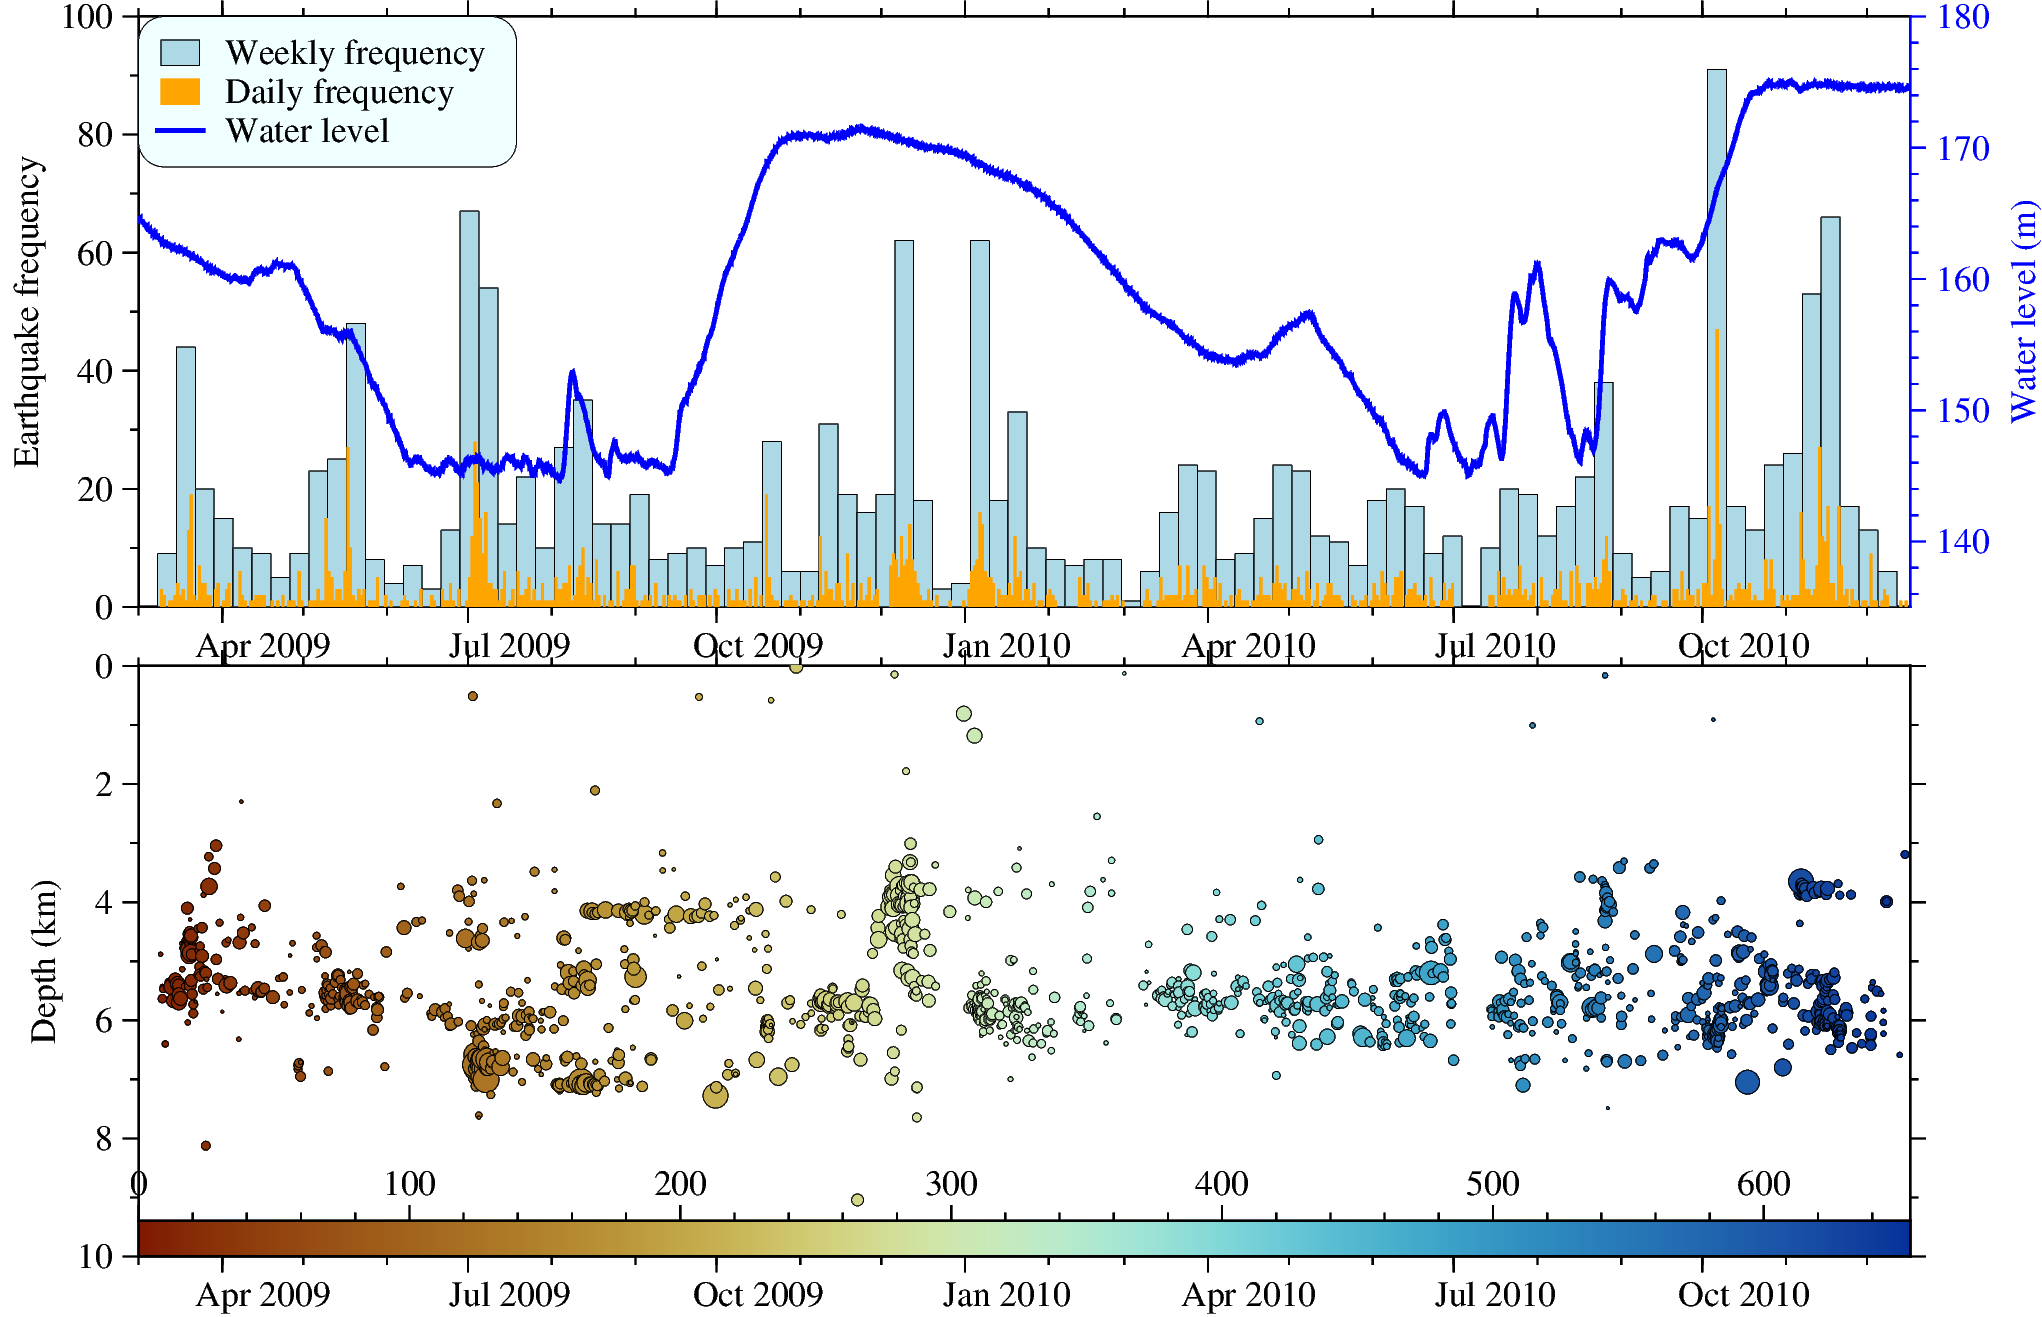

In [19]:
fig = pygmt.Figure()
pygmt.config(FONT='8.5p',MAP_FRAME_TYPE='plain')
fig.basemap(region=[t1,t2,0,100],projection='X15c/5c',frame=['xaf','yaf+lEarthquake frequency','WSn'])
fig.histogram(data=catalog.time,series='1w',fill='lightblue',pen='0.1p',label='Weekly frequency')
fig.histogram(data=catalog.time,series='1d',fill='orange',label='Daily frequency')
#fig.plot(x=catalog.time,y=catalog.magnitude,style='b0.01c')
with pygmt.config(MAP_FRAME_PEN="blue",MAP_TICK_PEN="blue",FONT_ANNOT_PRIMARY="blue",FONT_LABEL="blue"):
    fig.basemap(region=[t1,t2,135,180],projection='X15c/5c',frame=['xaf','yaf+lWater level (m)','E'])
    fig.plot(x=water_level.time,y=water_level.water_level,pen='1p,blue',label='Water level')
fig.legend(position='jTL+w3.2c+o0.0c/0.0c',box='+gazure1+p0.1p+r')

fig.shift_origin(yshift='-5.5c')
fig.basemap(region=[t1,t2,0,10],projection='X15c/-5c',frame=['xaf','yaf+lDepth (km)','WSen'])
pygmt.makecpt(cmap='roma',series=[0,catalog.reltime.max(),1],continuous=True,output='time.cpt')
fig.plot(x=catalog.time,y=catalog.depth,style='cc',size=0.06*(catalog.magnitude+1),pen='0.1p',fill=catalog.reltime,cmap='time.cpt')
fig.colorbar(position='jBC+w15c/0.3c+o0.0c/0.0c+ml+h',frame=['xaf'],cmap='time.cpt')
fig.show()

In [20]:
from plot_utils import plot_profile_location,project_data

In [21]:
# N1N2
lat_N1,lon_N1 = sdc.redist(xkm=-7,ykm=2,olat=31.0,olon=110.5,rota=0)
lat_N2,lon_N2 = sdc.redist(xkm=10,ykm=2,olat=31.0,olon=110.5,rota=0)
P_N = [lon_N1,lat_N1,lon_N2,lat_N2]

In [22]:
lon1,lat1,lon2,lat2 = P_N
reloc = pygmt.project(data=catalog[['longitude','latitude','depth','magnitude','reltime']],
                      center=[lon1,lat1],endpoint=[lon2,lat2],
                      length=None,width=None,unit=True)
reloc.columns = ['longitude','latitude','depth','magnitude','reltime','p','q','r','s']
reloc.loc[:,'time'] = catalog['time'].values

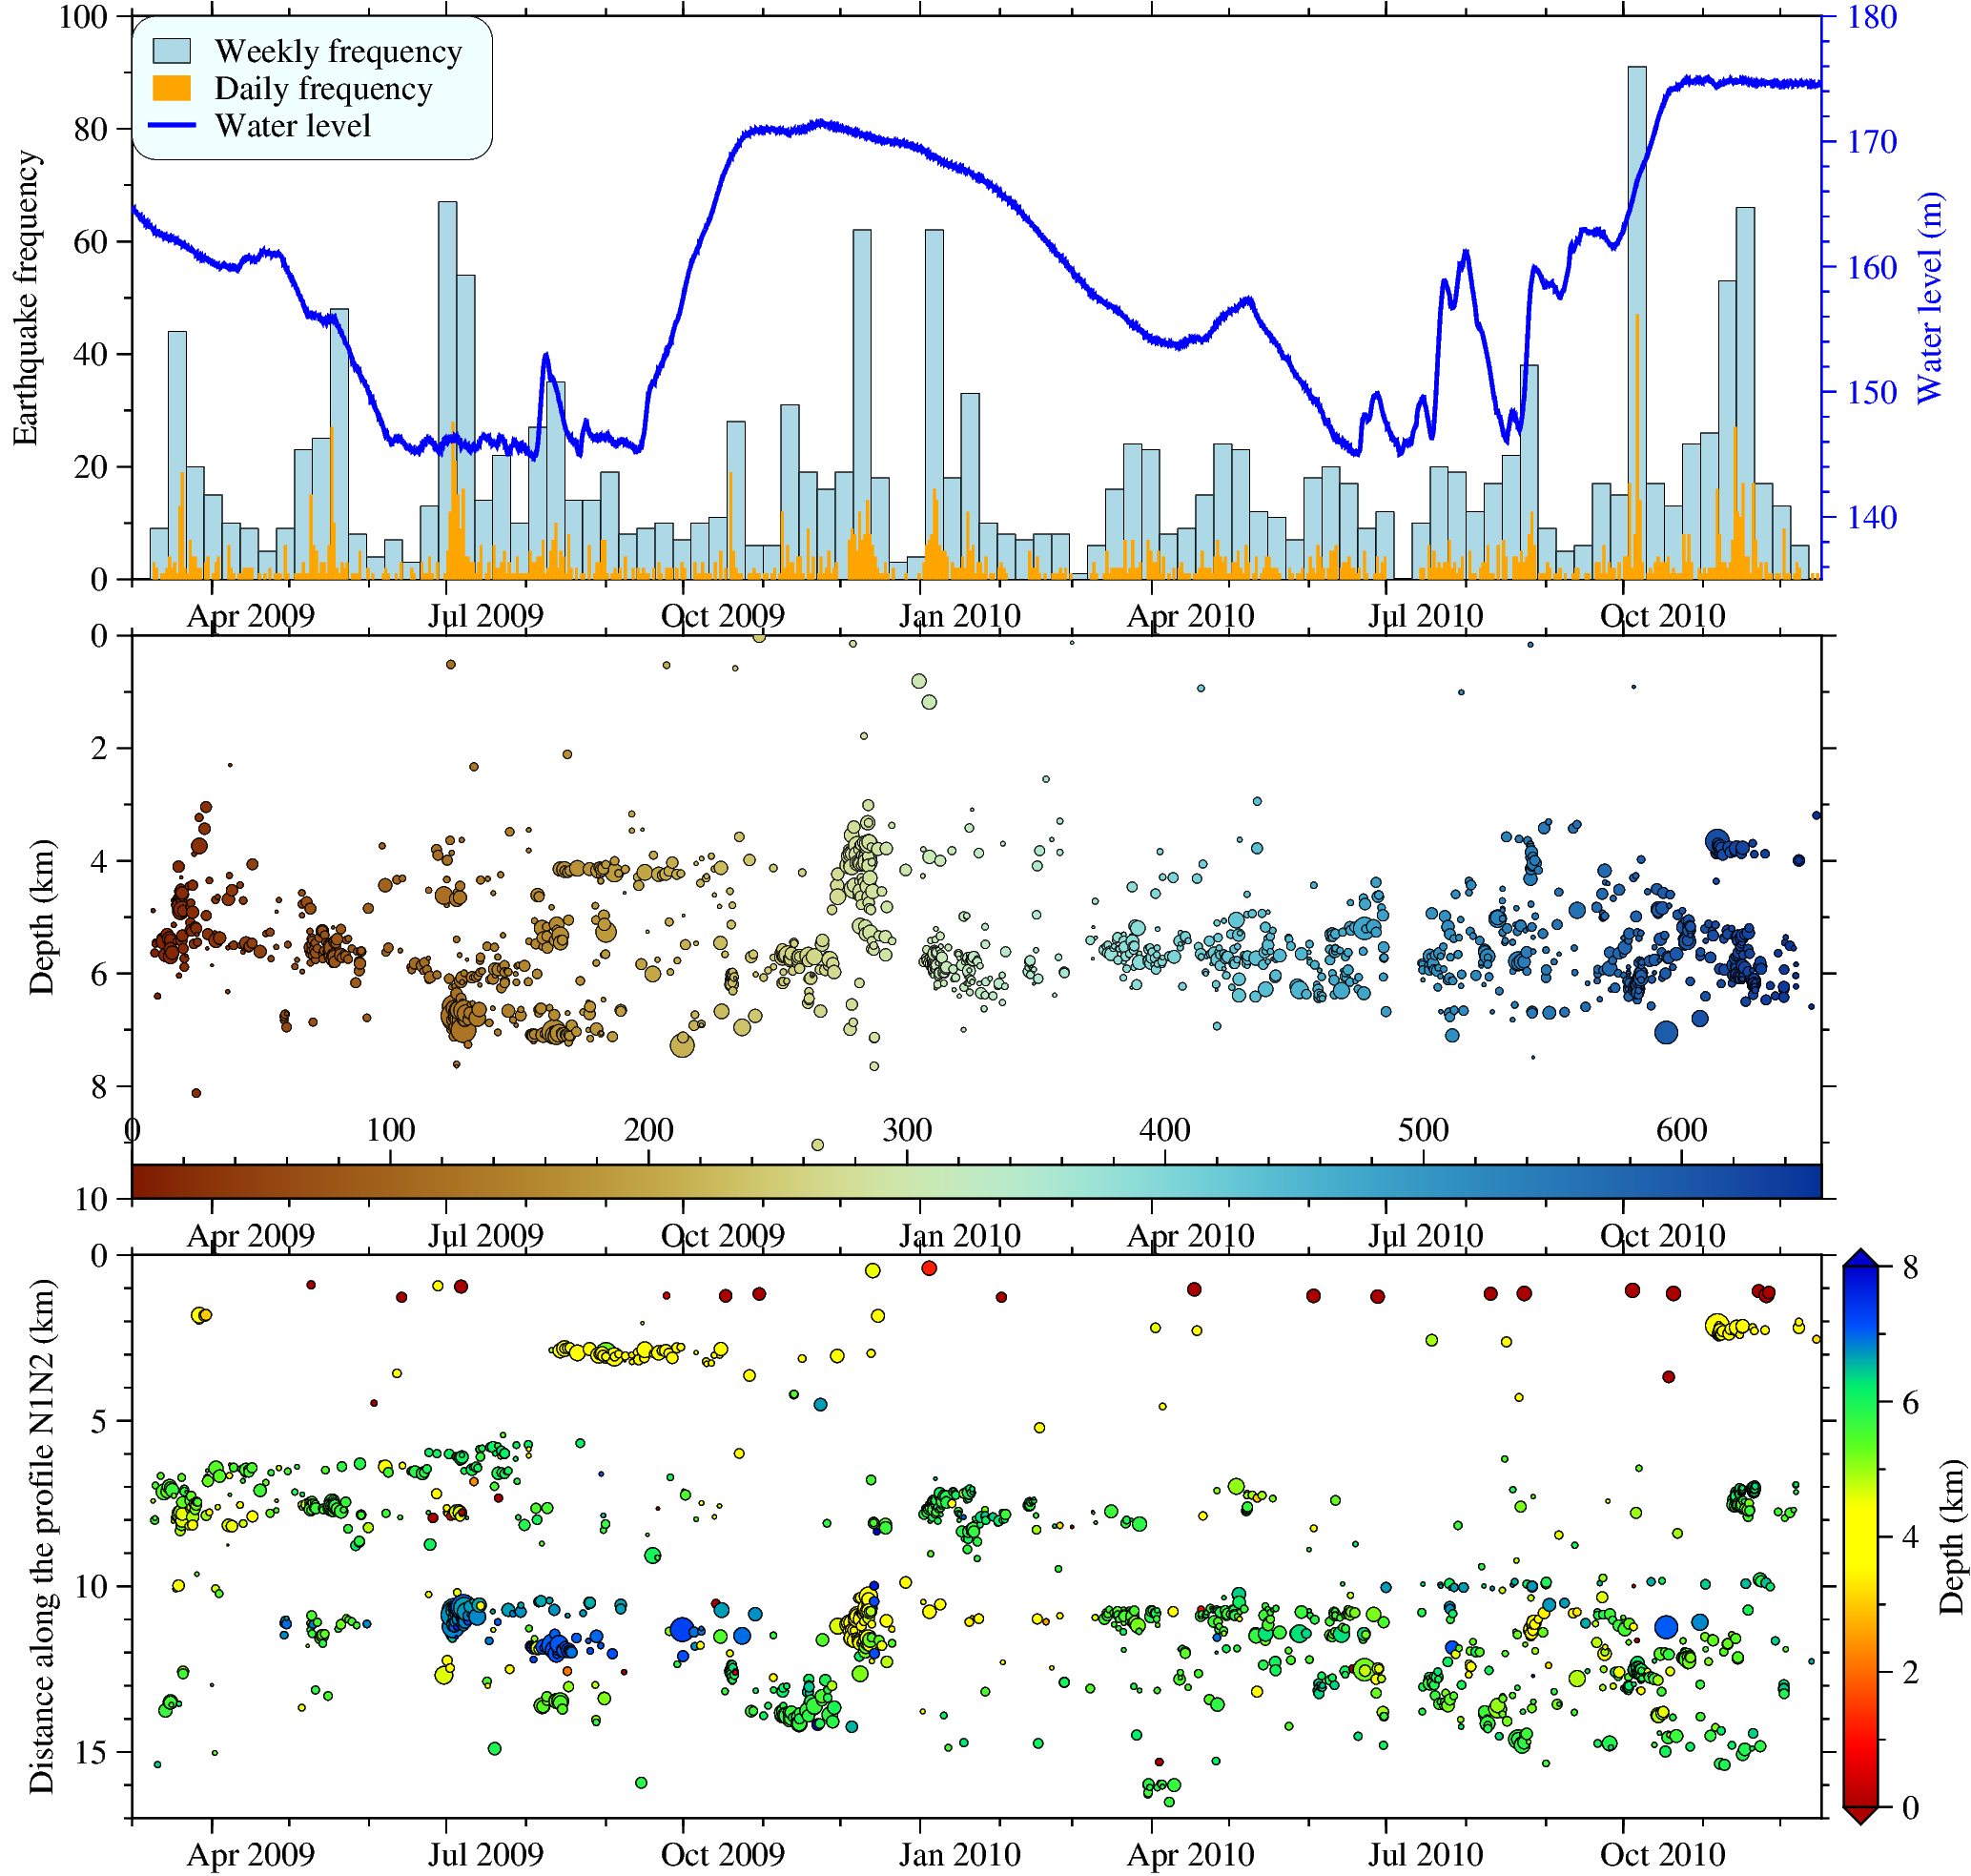

In [23]:
fig.shift_origin(yshift='-5.5c')
fig.basemap(region=[t1,t2,0,17],projection='X15c/-5c',frame=['xaf','yaf+lDistance along the profile N1N2 (km)','WSen'])
pygmt.makecpt(cmap='seis',series=[0,8,0.1],background=True,continuous=True,output='depth.cpt')
fig.plot(x=reloc['time'],y=reloc['p'],style='cc',size=0.06*(reloc.magnitude+1),fill=reloc.depth,cmap='depth.cpt',pen='0.2p')
fig.colorbar(position='JMR+w4.8c/0.3c+o0.2c/0c+e',cmap='depth.cpt',frame=['xaf+lDepth (km)'])
fig.show()

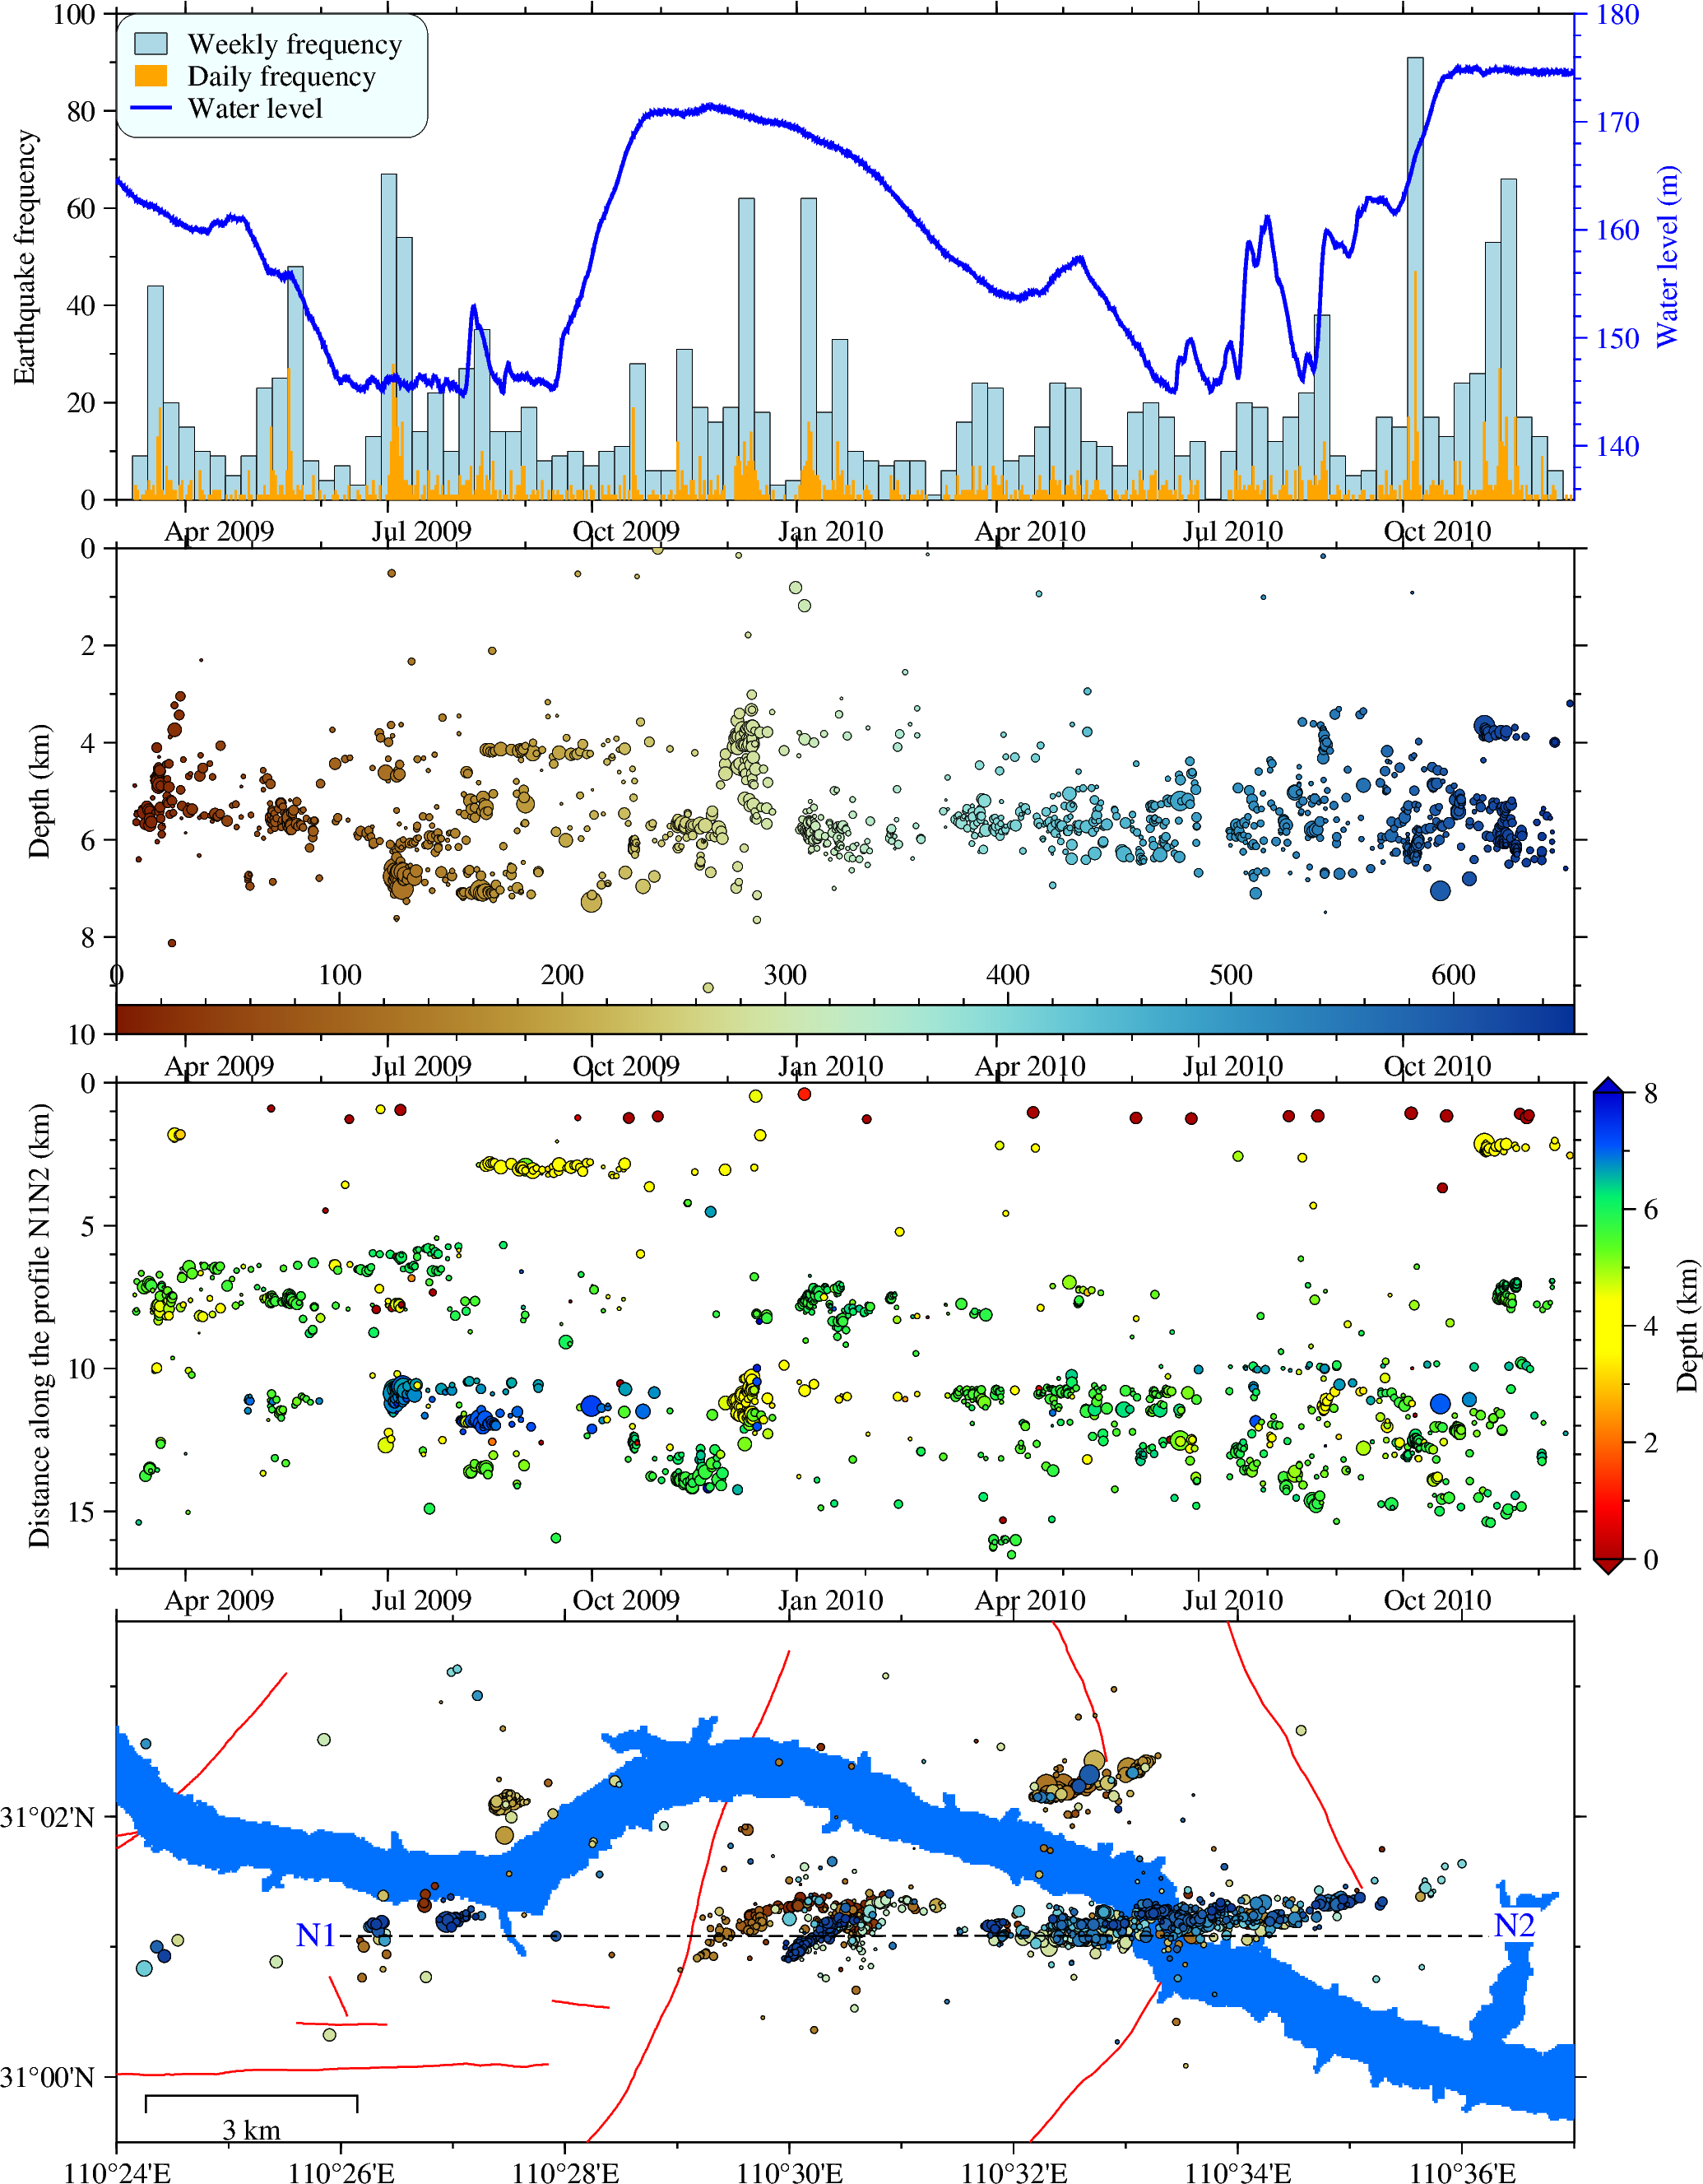

In [24]:
fig.shift_origin(yshift='-5.9c')
fig.basemap(region=region,projection='M15c',frame=['af','WSen'])
# plot the faults and map_scale
fig.plot(data=faults,pen='0.5p,red')
fig.basemap(map_scale='jBL+c110.5/31+w3k+l+o0.3c/0.3c')
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False)
fig.plot(x=catalog.longitude,y=catalog.latitude,style='cc',size=0.06*(catalog.magnitude+1),fill=catalog.reltime,cmap='time.cpt',pen='0.2p')

length_N = plot_profile_location(fig,P_N,label=['N1','N2'])
fig.show()

In [27]:
fig.savefig('plotting_figures'+os.sep+'FigureS11_Water_level.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'FigureS11_Water_level.pdf')

In [26]:
for file in glob.glob('*.cpt'):
    os.remove(file)